In [1]:
import prepare_sample
import os
import numpy as np
from my_functions import astro_utility as au
from astropy.table import Table
import sys
sys.path.append("../..")
from qsogen import model_colours
from qsogen import fast_sed
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import fitting_library as fl
from gibbs_sampler import run_gibbs_sampler, ProposalConfig


In [2]:
sample = prepare_sample.prepare_sample(return_only_magnitudes=False);
sample = prepare_sample.color_container_class(sample)
sample.process_pipeline()

Transforming SDSS.u to AB, i.e. adding 0.0
Transforming SDSS.g to AB, i.e. adding 0.0
Transforming SDSS.r to AB, i.e. adding 0.0
Transforming SDSS.i to AB, i.e. adding 0.0
Transforming SDSS.z to AB, i.e. adding 0.0
Transforming UKIDSS.Y to AB, i.e. adding 0.6147726766033728
Transforming UKIDSS.J to AB, i.e. adding 0.9152606087248839
Transforming UKIDSS.H to AB, i.e. adding 1.3520471317250795
Transforming UKIDSS.K to AB, i.e. adding 1.8713980229183953
Transforming WISE.W1 to AB, i.e. adding 2.6787715820675913
Transforming WISE.W2 to AB, i.e. adding 3.3151986991103968
Keeping 35280 QSOs with 45.5 <= L < inf  at lambda = 5100 A
Keeping 35280 QSOs with 0 <= UKIDSS.Y <= 28
Keeping 24963 QSOs with err_SDSS.u < 0.1
Keeping 24911 QSOs with err_SDSS.g < 0.1
Keeping 24873 QSOs with err_SDSS.r < 0.1
Keeping 24828 QSOs with err_SDSS.i < 0.1
Keeping 23980 QSOs with err_SDSS.z < 0.1
Keeping 23593 QSOs with err_UKIDSS.Y < 0.1
Keeping 22666 QSOs with err_UKIDSS.J < 0.1
Keeping 19531 QSOs with err_UKID

In [2]:
interps = fast_sed.make_interps()
grid = fast_sed.build_template_grid(interps)
filter_properties = model_colours.get_filters_properties()

In [4]:
y = sample.colors
yerr = sample.colors_errors
redshift = sample.redshift
m_i = sample.M_i

In [13]:
Nbins = 50
Nagn = y.shape[0]
N_parameters = 5
plslp1 = np.linspace(-1, 0.2, Nbins+1)
plslp2 = np.linspace(-0.5, 0.7, Nbins+1)
wavbreak = np.linspace(2000, 6000, Nbins+1)
tbb = np.linspace(400, 2500, Nbins+1)
bbnorm = np.linspace(0, 5, Nbins+1)

hist_edges = np.column_stack((plslp1, plslp2, wavbreak, tbb, bbnorm)).T
hist_weights = fl.initilize_histogram_weights(N_parameters, Nbins)


In [14]:
from gibbs_sampler import run_gibbs_sampler, ProposalConfig

# Per-parameter proposal strategies:
#   plslp1   : fractional (negative values, step ~ 5% of |x|)
#   plslp2   : additive   (near zero, fixed step width)
#   wavbreak : additive   (bounded range 2000-4000, fixed step)
#   tbb      : log_normal (strictly positive, multiplicative step)
#   bbnorm   : log_normal (strictly positive, multiplicative step)
proposal_configs = [
    ProposalConfig(strategy="additive",  scale = 0.05),   # plslp1
    ProposalConfig(strategy="additive",   scale=0.05),   # plslp2
    ProposalConfig(strategy="additive",   scale=50.0),   # wavbreak
    ProposalConfig(strategy="log_normal", scale=0.05),   # tbb
    ProposalConfig(strategy="log_normal", scale=0.05),   # bbnorm
]

result = run_gibbs_sampler(
    y=y,
    yerr=yerr,
    redshift=redshift,
    m_i=m_i,
    hist_edges=hist_edges,
    grid=grid,
    filter_properties=filter_properties,
    n_steps=1000,
    proposal_configs=proposal_configs,
    adapt_every=50,
    target_acceptance=0.35,
    seed=42,
    verbose=True,
    save_every=1,
)

trace_param = result.trace_param
trace_hist = result.trace_hist
print(f"Final scales: {result.scales_final}")

step   50 | accept 52.17% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  100 | accept 43.70% | scales: ['0.0845', '0.0845', '84.5', '0.0845', '0.0845']
step  150 | accept 32.32% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  200 | accept 38.68% | scales: ['0.0845', '0.0845', '84.5', '0.0845', '0.0845']
step  250 | accept 29.29% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  300 | accept 36.62% | scales: ['0.0845', '0.0845', '84.5', '0.0845', '0.0845']
step  350 | accept 27.64% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  400 | accept 34.35% | scales: ['0.05', '0.05', '50', '0.05', '0.05']
step  450 | accept 40.98% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  500 | accept 32.57% | scales: ['0.05', '0.05', '50', '0.05', '0.05']
step  550 | accept 39.09% | scales: ['0.065', '0.065', '65', '0.065', '0.065']
step  600 | accept 31.45% | scales: ['0.05', '0.05', '50', '0.05', '0.05']
step  650 | accept 36.94% | scales: ['0.065', 

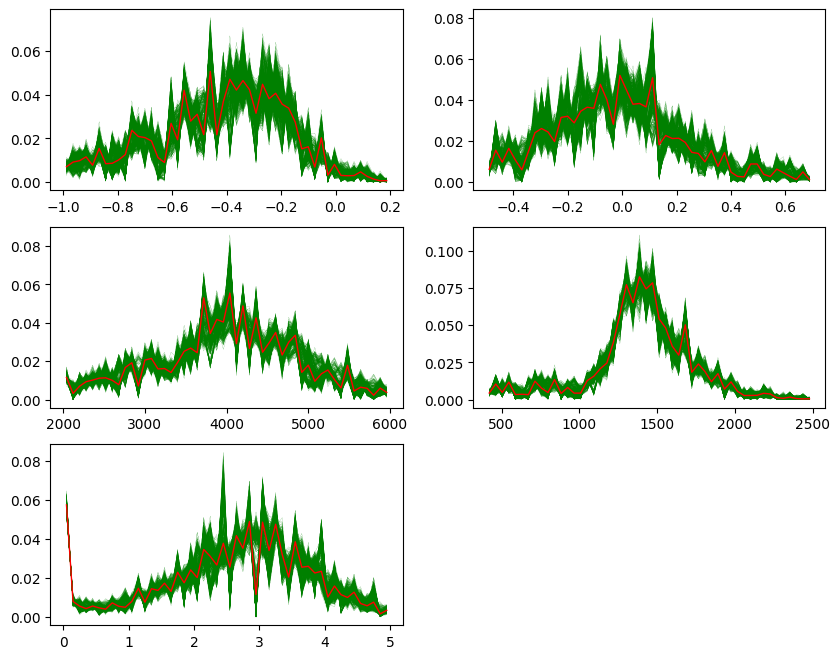

In [20]:
fig, axs = plt.subplots(nrows = 3, ncols =2, figsize = (10,8))
for idx, ax in enumerate(axs.flatten()):
    if idx >4:
        break
    xpos = 0.5*(hist_edges[idx,:-1]+hist_edges[idx,1:])
    mean = np.quantile(trace_hist[200:, idx, :], 0.5, axis = 0)
    for i in range(200,trace_hist.shape[0],1):
        ax.plot(xpos,trace_hist[i, idx, :], lw = 0.1, c = "g")
    ax.plot(xpos, mean, lw = 1, c = "r")
axs[2,1].remove()

In [28]:
Nsamples = 30000
redshift_fake = np.linspace(0, 3.5, 30000)
Mi_fake = -27 + np.random.randn(Nsamples)
median_hist = np.quantile(trace_hist[200:, :, :], 0.5, axis = 0)
median_hist/= median_hist.sum(axis=1, keepdims=True)
params = fl.sample_from_hist(Nsamples, hist_edges, median_hist)

In [29]:
theta = np.column_stack((redshift_fake, params, Mi_fake ))
fake_colors = fast_sed.get_colours_fast(theta, grid, filter_properties)

Text(0, 0.5, 'g-r')

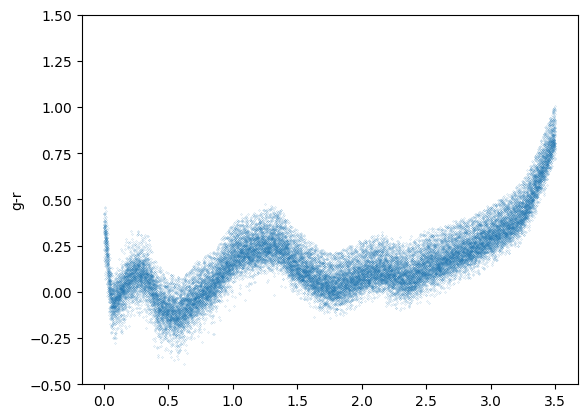

In [38]:
idx = 1
fig, ax = plt.subplots()
ax.scatter(redshift_fake, fake_colors[:, idx], s =0.01)
ax.set_ylim(-0.5, 1.5)
ax.set_ylabel("g-r")

In [4]:
Nbins = 50
Nagn = 20000
N_parameters = 5
plslp1 = np.linspace(-1, 0.2, Nbins+1)
plslp2 = np.linspace(-0.5, 0.7, Nbins+1)
wavbreak = np.linspace(2000, 6000, Nbins+1)
tbb = np.linspace(400, 2500, Nbins+1)
bbnorm = np.linspace(0, 5, Nbins+1)

hist_edges = np.column_stack((plslp1, plslp2, wavbreak, tbb, bbnorm)).T
hist_weights = fl.initilize_histogram_weights(N_parameters, Nbins)
interps = fast_sed.make_interps()
grid = fast_sed.build_template_grid(interps)
filter_properties = model_colours.get_filters_properties()

In [5]:
theta = fl.sample_from_hist(Nagn, hist_edges, hist_weights)
theta = np.column_stack([np.linspace(0.01, 3, Nagn), theta, -27*np.ones(Nagn)])
y = np.random.randn(Nagn, 10)
yerr = np.random.randn(Nagn, 10)

In [6]:
#timeit
a = fl.log_likelihood(theta, y, yerr, grid, filter_properties )

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUntyped global name 'get_colours_fast':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "fitting_library.py", line 17:[0m
[1mdef log_likelihood(theta, y, yerr, grid, filters_properties,
    <source elided>
    
[1m    model = get_colours_fast(theta, grid, filters_properties,
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 4: [1mCannot determine Numba type of <class 'tuple'>[0m


(20000,)

In [3]:


parameters = fl.sample_from_hist(Nsamples, hist, hist_weights)
prior = fl.log_prior_from_hist(parameters, hist, hist_weights)


In [119]:
hist.shape

(6, 41)

In [ ]:
nu_histogram = np.random.dirichlet(alpha = np.ones(nbins))

Nsteps = 800

z_current = sample_from_hist(Nagn, nbins, nu_histogram)

trace_z =[z_init]
trace_nu = [nu_histogram]

for step in range(Nsteps):
    nu_frozen = trace_nu[step]
    for i in range(Nagn):
        z_old = z_current[i]
        y = data[i]
        z_prop = z_old + np.random.normal(0, 0.02)
        if (z_prop < grid_z[0]) or (z_prop > grid_z[-1]):
            continue
        logpost_old = log_likelihood(y, sigma_noise, z_old) + log_prior_from_hist(z_old, grid_z, nu_frozen)
        logpost_prop = log_likelihood(y, sigma_noise, z_prop) + log_prior_from_hist(z_prop, grid_z, nu_frozen)
        if np.log(np.random.rand()) < (logpost_prop - logpost_old):
            z_current[i] = z_prop
    z_frozen = z_current
    idxs = np.digitize(z_frozen, grid_z)-1
    counts = np.bincount(idxs, minlength=nbins)
    nu_updated = np.random.dirichlet(alpha = (np.ones(nbins)+counts))
    trace_z.append(z_current.copy())
    trace_nu.append(nu_updated.copy())
    if step % 50 == 0:
        print(f"step {step:3d}")

trace_z = np.array(trace_z)   
trace_nu = np.array(trace_nu)     

In [ ]:
theta = 

In [74]:
def sample_from_hist(nsamples, hist_edges, hist_weights):
    N_parameters, N_bins = hist_weights.shape
    parameters = np.empty((nsamples, N_parameters))
    for p in range(N_parameters):
        bins = np.random.choice(N_bins, size=nsamples, p=hist_weights[p])
        parameters[:, p] = (
            hist_edges[p, bins]
            + np.random.rand(nsamples)
            * (hist_edges[p, bins+1] - hist_edges[p, bins])
        )
    return parameters


In [ ]:
for step in range(Nsteps):
    nu_frozen = trace_nu[step]
    for i in range(Nagn):
        z_old = z_current[i]
        y = data[i]
        z_prop = z_old + np.random.normal(0, 0.02)
        if (z_prop < grid_z[0]) or (z_prop > grid_z[-1]):
            continue
        logpost_old = log_likelihood(y, sigma_noise, z_old) + log_prior_from_hist(z_old, grid_z, nu_frozen)
        logpost_prop = log_likelihood(y, sigma_noise, z_prop) + log_prior_from_hist(z_prop, grid_z, nu_frozen)
        if np.log(np.random.rand()) < (logpost_prop - logpost_old):
            z_current[i] = z_prop
    z_frozen = z_current
    idxs = np.digitize(z_frozen, grid_z)-1
    counts = np.bincount(idxs, minlength=nbins)
    nu_updated = np.random.dirichlet(alpha = (np.ones(nbins)+counts))
    trace_z.append(z_current.copy())
    trace_nu.append(nu_updated.copy())
    if step % 50 == 0:
        print(f"step {step:3d}")

trace_z = np.array(trace_z)   
trace_nu = np.array(trace_nu)     

In [95]:
for step in range(Nsteps):
    nu_frozen = trace_nu[step]
    for i in range(Nagn):
        z_old = z_current[i]
        y = data[i]
        z_prop = z_old + np.random.normal(0, 0.02)
        if (z_prop < grid_z[0]) or (z_prop > grid_z[-1]):
            continue
        logpost_old = log_likelihood(y, sigma_noise, z_old) + log_prior_from_hist(z_old, grid_z, nu_frozen)
        logpost_prop = log_likelihood(y, sigma_noise, z_prop) + log_prior_from_hist(z_prop, grid_z, nu_frozen)
        if np.log(np.random.rand()) < (logpost_prop - logpost_old):
            z_current[i] = z_prop
    z_frozen = z_current
    idxs = np.digitize(z_frozen, grid_z)-1
    counts = np.bincount(idxs, minlength=nbins)
    nu_updated = np.random.dirichlet(alpha = (np.ones(nbins)+counts))
    trace_z.append(z_current.copy())
    trace_nu.append(nu_updated.copy())
    if step % 50 == 0:
        print(f"step {step:3d}")

trace_z = np.array(trace_z)   
trace_nu = np.array(trace_nu)     

(15000, 6)

In [97]:
def log_prior_from_hist(parameters, hist_edges, hist_weights):
    N_samples, N_parameters = parameters.shape
    idxs = np.empty_like(parameters, dtype=int)
    for p in range(N_parameters):
        idxs[:, p] = np.digitize(parameters[:, p], hist_edges[p]) - 1 
    bins_widths = hist_edges[:,1] - hist_edges[:,0]
    probs =  hist_weights[idxs]
    dens = probs / bins_widths
    return np.log(dens + 1e-300) 

hist_

In [ ]:
def log_prior_from_hist(z, grid_z, nu_histogram):
    idx = np.digitize(z, grid_z) - 1 
    bin_width = grid_z[1] - grid_z[0]
    probs = nu_histogram[idx]
    dens = probs / bin_width
    return np.log(dens + 1e-300) 

In [93]:
bins = np.empty_like(z, dtype=int)
for p in range(N_parameters):
    bins[:, p] = np.digitize(
        z[:, p],
        hist[p]
    ) - 1 

In [89]:
z.shape

(15000, 6)

In [38]:
def make_interps():
    """Build the interps dict the same way the original code expects."""
    maindir = os.path.expanduser("~/WORK/qsogen_master/qsogen")
    f1 = os.path.join(maindir,'qsosed_emlines_20210625.dat')
    emline= np.genfromtxt(f1, unpack=True)
    wavs = emline[0]
    med = emline[1]
    con = emline[2]
    pky = emline[3]
    wdy = emline[4]

    interps = {
        'med': interp1d(wavs, med, kind='linear', bounds_error=False, fill_value=np.nan),
        'pky': interp1d(wavs, pky, kind='linear', bounds_error=False, fill_value=np.nan),
        'wdy': interp1d(wavs, wdy, kind='linear', bounds_error=False, fill_value=np.nan),
        'con': interp1d(wavs, con, kind='linear', bounds_error=False, fill_value=np.nan),
    }
    return interps

In [58]:
N = 15000
redshift  =np.linspace(0.001,0.002, N )
plspl1 = -0.34*np.ones(N) #+ np.random.randn(N)
plspl2 = 0.05 * np.ones(N) 
wavbreak = 3500*np.ones(N) 
tbb = 1200*np.ones(N) 
bbnorm = 2.5 * np.ones(N) 
M_i = -27 *np.ones(N) 
theta = np.ascontiguousarray(np.column_stack([redshift, plspl1, plspl2, wavbreak, 
                         tbb, bbnorm, M_i]))

In [59]:
obs_wav_sorted, sparse_W = model_colours.get_filters_properties()
#obs_wav_sorted = np.logspace(2.8, 4.3, 1000)
interps = make_interps()
grid = fast_sed.build_template_grid(interps)

In [60]:
#fluxes = fast_quasar_sed_for_fitting(theta, obs_wav_sorted, interps=interps)

In [61]:
fluxes2 = fast_sed.fast_quasar_sed(theta, obs_wav_sorted, grid,
                                    wavbrk3 = 1200,
                                    plslp3_step = -1,
                                    scalin = 0.9,
                                    beslope = 0.183,
                                    benrm = -27.0,
                                    cont_norm_wav = 5500.0)

In [62]:
colors = fast_sed.get_colours_fast(theta, grid, (obs_wav_sorted, sparse_W))

In [63]:
colors.shape

(15000, 10)

(0.0001, 0.01)

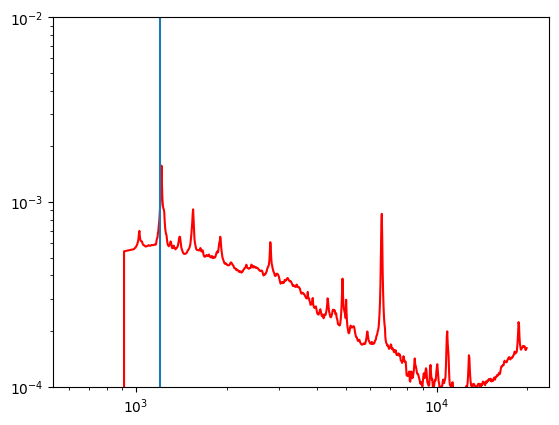

In [49]:
idx = 5
fig, ax = plt.subplots()
#ax.plot(obs_wav_sorted, obs_wav_sorted*fluxes[idx, :])
ax.plot(obs_wav_sorted/(theta[idx,0]+1), obs_wav_sorted*fluxes2[idx, :], c ="r")
ax.axvline(1200)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-4,1e-2)

In [23]:
obs_wav_sorted

array([ 2980.,  3005.,  3030., ..., 55400., 55500., 55600.], shape=(3131,))

In [7]:
redshift  =np.linspace(0.05,4, N )
plspl1 = -0.34*np.ones(N) #+ np.random.randn(N)
plspl2 = 0.05 + np.random.randn(N)
wavbreak = 3500*np.ones
tbb = 1200 + 500*np.random.randn(N)
bbnorm = 2 + np.random.randn(N)
M_i = -27 + np.random.randn(N)

array([ 7.08355279e-01, -3.40000000e-01,  1.60293245e+00,  2.07889365e+03,
        2.84113302e+01,  1.30866754e+00, -2.65114705e+01])

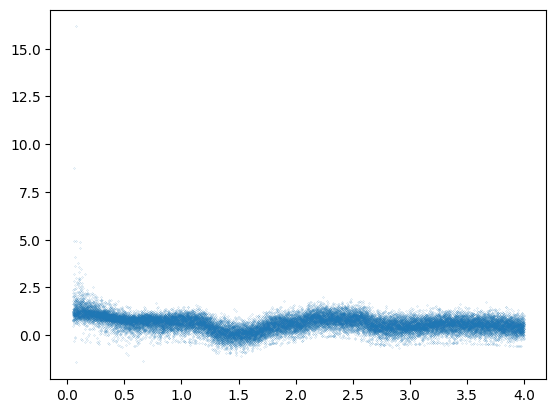

In [57]:
idx = 7
fig, ax = plt.subplots()
#ax.plot(obs_wav_sorted, obs_wav_sorted*fluxes[idx, :])
ax.scatter(redshift, colors[:, idx], s =0.01)


In [31]:
import numpy as np

x = 10.0
scale = 0.1
rng = np.random.default_rng()
save =[]
# Simulate 1000 steps
for _ in range(100000):
    x *= np.exp(rng.normal(0, scale)) +1e-20
    save.append(x)

print(f"Final value after 1000 steps: {x:.2f}") 
# It will likely still be in the general neighborhood of 10

Final value after 1000 steps: 283740.92


In [32]:
import matplotlib.pyplot as plt

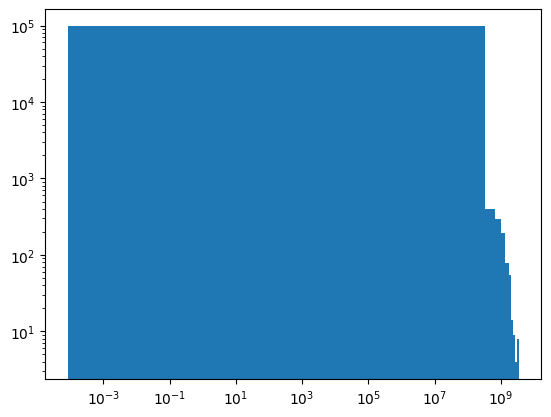

In [36]:
plt.hist(save);

plt.xscale("log")
plt.yscale("log")